In [5]:
import os
import glob
from collections import defaultdict
import random


import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset,DataLoader
import cv2 as cv
import imagesize
import torchvision.transforms as T
from PIL import Image
from joblib import Parallel, delayed
from 


#### Create Dataset

In [16]:
class NoTrashDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.dataset_path = os.path.join(root_dir,"train/notrash/**/*.png")
        self.train_files = glob.glob(self.dataset_path, recursive=True)

        if not transform:
            # if no transform is passed do a resize
            tf = T.Compose([T.Resize((256,256)), T.ToTensor()])
            self.transform = tf

    def __len__(self):
        return len(self.train_files)


    def __getitem__(self, idx):
        img_path = self.train_files[idx]
        img = Image.open(img_path)

        if self.transform:
            img = self.transform(img)
        return img

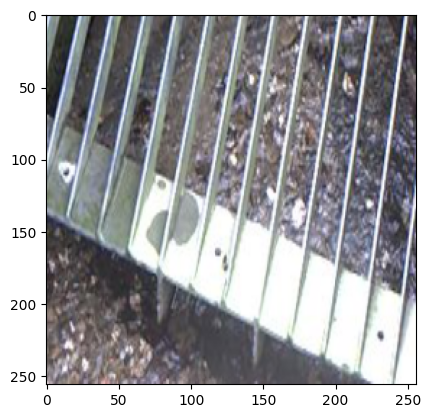

In [20]:
dataset = NoTrashDataset("../student_db")
plt.imshow(dataset[0].permute(1, 2, 0) )

'../student_db/train/notrash/**/*.png'